<a href="https://colab.research.google.com/github/amitkumar981/Learn_RAG/blob/master/adaptive_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#data processing
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate
from langchain.chat_models import init_chat_model
from langchain_openai.embeddings import OpenAIEmbeddings

e:\desktop backup\RAG\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [ ]:
# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [ ]:
#configure retriever
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap =50)
docs_splits = text_splitter.split_documents(docs_list)
vector_store = FAISS.from_documents(docs_splits,OpenAIEmbeddings())
retriever = vector_store.as_retriever()
retriever.invoke("what is prompt engineering?")


[Document(id='1f05fa06-ae4d-4d58-b526-d52bf8cfb3b6', metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log", 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en'}, page_content='Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for

In [ ]:
#configure llm
llm = init_chat_model(model ='openai:gpt-4o-mini',temperature=0.2)
llm.invoke('hi')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-Ct0rO2sLglG8CfxgtjguvY7vxtgF0', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b76f5-d268-7852-b434-4c0ddd372272-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
#def state
from typing import List
from typing_extensions import TypedDict
from langchain_core.documents import Document

class RAGState(TypedDict):
    question: str
    answer: str
    documents:List[Document]
    datasource: str
    doc_grade:str
    hellucinations:str
    awswer_grade:str
    retry_count: int

In [ ]:
#configure query analysis node
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel,Field
from typing_extensions import Literal
def  QueryAnalysis(state):
    "analyse the query"
    print('ANALYSING QUERY...')
    question = state['question']
    system = """You are an expert at routing a user question to a vectorstore or web search.
    The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
    Use the vectorstore for questions on these topics. Otherwise, use web-search."""
    route_prompt = ChatPromptTemplate.from_messages([
        ('system',system),
        ('human','{question}')
    ])
    class RouteQuery(BaseModel):
        """Route a user query to the most relevant datasource."""
        datasource: Literal['retrieve','web_search'] = Field(description="Given a user question choose to route it to web search or a retrieve.")
    model = llm.with_structured_output(RouteQuery)
    route = model.invoke(route_prompt.format(question=question))
    return {'datasource':route.datasource}


In [ ]:
#test the node
state = RAGState(question='what is concept of prompt engineering',answer='',documents = [])
query_analysis = QueryAnalysis(state)
query_analysis

ANALYSING QUERY...


{'datasource': 'retrieve'}

In [ ]:
#define wesearch node
from langchain_community.tools.tavily_search import TavilySearchResults
def web_search(state):
    "search web for get the relevant documents for the query"
    print('WEBSEARCH...')
    question = state['question']
    search_tool = TavilySearchResults(k=4)
    search_results=search_tool.invoke(question)
    docs="\n".join([doc['content'] for doc in search_results])
    return {'documents':docs,'question':question}

In [ ]:
#def retrieve node
def retrieve(state):
    "retrieve the relevant documents for the query"
    print('RETRIEVING...')
    question = state['question']
    docs = retriever.invoke(question)
    #docs="\n".join([doc.page_content for doc in docs])
    return {'documents':docs,'question':question}

In [ ]:
#define router for query
def query_router(state):
    "route the query to the relevant datasource"
    print('ROUTING...')
    if state['datasource'] == 'web_search':
        return "web_search"
    elif state['datasource'] == 'retrieve':
        return "retrieve"


In [ ]:
from typing_extensions import Literal
from pydantic import BaseModel, Field

def DocumentGrader(state):
    """Grade retrieved documents for relevance to the query"""
    print("GRADING RETRIEVED DOCUMENTS...")

    question = state["question"]
    documents = state["documents"]

    if not documents:
        return {
            "doc_grade": "no",
            "documents": []
        }

    doc_text = "\n\n".join(doc.page_content for doc in documents)

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an expert at grading documents for relevance to a user query."),
        ("human", "Question:\n{question}\n\nDocuments:\n{document}")
    ])

    class GradeDocuments(BaseModel):
        binary_score: Literal["yes", "no"] = Field(
            description="Whether the documents are relevant to the query"
        )

    grader = llm.with_structured_output(GradeDocuments)

    response = grader.invoke(
        prompt.format(question=question, document=doc_text)
    )

    return {
        "doc_grade": response.binary_score,
        "documents": documents
    }


In [ ]:
def document_router(state):
    "route the documents to the relevant datasource"
    print('ROUTING...')
    if state['doc_grade'] == 'yes':
        return "generate"
    elif state['doc_grade'] == 'no':
        return "rewrite"

In [ ]:
#define a node for rewrite the query
def rewrite_query(state):
    "formulate the question for better retrieval"
    print('REWRITING QUERY...')
    question = state['question']
    prompt = ChatPromptTemplate.from_messages([
        ('system','You are an expert at rewriting a user query.formulate the question for better retrieval'),
        ('human','{question}')
    ])
    better_question = llm.invoke(prompt.format(question = question))
    return {'question':better_question,'retry_count':state['retry_count']+1}


In [ ]:
#define the node the generate the response
def Generate(state):
    "generate the response based on the retrieved documents"
    print('GENERATING ANSWER...')
    question = state['question']
    documents = state['documents']
    context = "\n\n".join(
        doc.page_content if isinstance(doc, Document) else str(doc)
        for doc in documents
    )
    prompt = ChatPromptTemplate.from_messages([
        ('system','You are answering a complex question using retrieved documents.'),
        ('human','Question:\n{question}\n\nRelevant Information:\n{context}\n\nNow synthesize a clear, accurate, and well-reasoned final answer.')
    ])
    response = llm.invoke(prompt.format(question = question,context = context))
    return {'answer':response.content.strip()}

In [ ]:
#define the node for check hellucinations
def check_hellucinations(state):
    "check if the query has hellucinations"
    print('CHECKING HELLUCINATIONS...')
    question = state['question']
    answer= state['answer']
    documents = state['documents']
    prompt = ChatPromptTemplate.from_messages([
        ('system','You are an expert at checking if a user query has hellucinations.'),
        ('human','question:\n{question}\n\ndocuments:\n{documents}\n\nanswer:\n{answer}')
    ])
    class CheckHellucinations(BaseModel):
        """Check if the query has hellucinations."""
        has_hellucinations:Literal['yes','no'] = Field(description="Whether the query has hellucinations.")
    answer_grader= llm.with_structured_output(CheckHellucinations)
    response = answer_grader.invoke(prompt.format(documents = documents,question = question,answer = answer))
    has_chellucinations = response.has_hellucinations
    return {'hellucinations':has_chellucinations}




In [ ]:
def hellucination_router(state):
    "route the query to the relevant datasource"
    print('ROUTING...')
    if state['hellucinations'] == 'yes':
        return "Generate"
    elif state['hellucinations'] == 'no':
        return "finalize"

In [ ]:
#define a node grade answer
def GradeGeneration(state):
    "grade the generated answer whether it is relevant to the query"
    print('GRADING ANSWER...')
    question = state['question']
    answer = state['answer']
    document = state['documents']
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an expert at grading whether a generated answer is relevant to the user question."),
        ("human",
         "question:\n{question}\n\n"
         "documents:\n{documents}\n\n"
         "answer:\n{answer}")]
      )
    class GradeGeneration(BaseModel):
        """Grade the generated answer whether it is relevant to the query."""
        binary_score:str = Field(description="Whether the answer is relevant to the query, 'yes' or 'no'.")
    answer_grader= llm.with_structured_output(GradeGeneration)
    response = answer_grader.invoke(prompt.format(question = question,answer = answer,documents = document))
    score =  response.binary_score
    return {'answer_grade':score}

In [ ]:
max_entries = 3
def final_router(state):
    "route the query to the relevant datasource"
    print('ROUTING...')
    if state['answer_grade'] == 'yes':
        return "end"
    elif state['retry_count'] > max_entries:
        return "end"
    elif state['answer_grade'] == 'no':
        return "rewrite"

In [ ]:
def finalize(state):
    "finalize the answer"
    print('FINALIZING ANSWER...')
    answer = state['answer']
    return {'answer':answer}

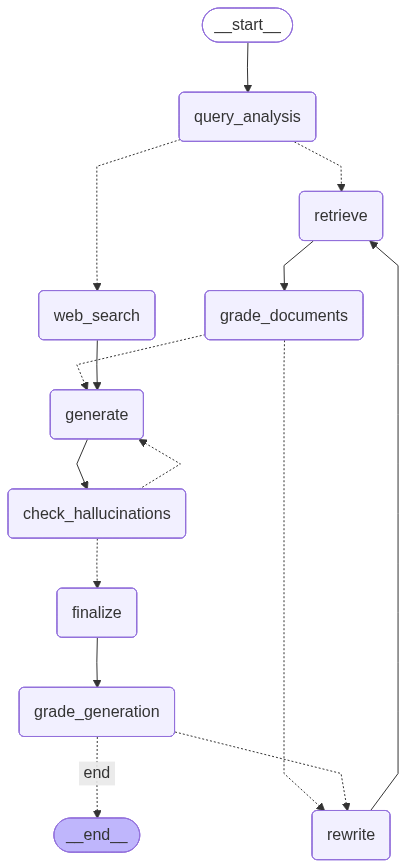

In [ ]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(RAGState)

# -----------------
# Nodes
# -----------------
graph_builder.add_node("query_analysis", QueryAnalysis)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("rewrite", rewrite_query)
graph_builder.add_node("generate", Generate)
graph_builder.add_node("grade_documents", DocumentGrader)
graph_builder.add_node("check_hallucinations", check_hellucinations)
graph_builder.add_node("finalize", finalize)
graph_builder.add_node("grade_generation", GradeGeneration)

# -----------------
# Entry
# -----------------
graph_builder.set_entry_point("query_analysis")

# -----------------
# Routing
# -----------------
graph_builder.add_conditional_edges(
    "query_analysis",
    query_router,
    {"web_search": "web_search", "retrieve": "retrieve"}
)

graph_builder.add_edge("web_search", "generate")
graph_builder.add_edge("retrieve", "grade_documents")

graph_builder.add_conditional_edges(
    "grade_documents",
    document_router,
    {"rewrite": "rewrite", "generate": "generate"}
)

graph_builder.add_edge("rewrite", "retrieve")
graph_builder.add_edge("generate", "check_hallucinations")

graph_builder.add_conditional_edges(
    "check_hallucinations",
    hellucination_router,
    {"generate": "generate", "finalize": "finalize"}
)

graph_builder.add_edge("finalize", "grade_generation")

graph_builder.add_conditional_edges(
    "grade_generation",
    final_router,
    {"rewrite": "rewrite", "": END}
)

graph = graph_builder.compile()
graph







In [ ]:
#test graph

state = RAGState(question='what is concept of prompt engineering?',answer='',documents = [],datasource="",binary_score='',hellucinations='',answer_grade='',retry_count=int(0))
graph.invoke(state)

ANALYSING QUERY...
ROUTING...
RETRIEVING...
GRADING RETRIEVED DOCUMENTS...
ROUTING...
GENERATING ANSWER...
CHECKING HELLUCINATIONS...
ROUTING...
FINALIZING ANSWER...
GRADING ANSWER...
ROUTING...


{'question': 'what is concept of prompt engineering?',
 'answer': "Prompt engineering, also known as In-Context Prompting, is a method used to effectively communicate with large language models (LLMs) to achieve desired outcomes without altering the model's weights. This practice is grounded in empirical science, as the effectiveness of different prompt engineering techniques can vary significantly across different models, necessitating extensive experimentation and the use of heuristics.\n\nAt its core, prompt engineering focuses on alignment and steerability of the model. It involves crafting prompts—sequences of tokens—that increase the likelihood of generating a specific output in response to a given input. These prompts can be treated as trainable parameters, which can be optimized directly in the embedding space using techniques such as AutoPrompt, Prefix-Tuning, P-tuning, and Prompt-Tuning. The evolution of these methods shows a trend towards simplification in setup and implemen

In [ ]:
state = RAGState(question='explain machine learning?',answer='',documents = [],datasource="",binary_score='',hellucinations='',answer_grade='',retry_count=int(0))
graph.invoke(state)

ANALYSING QUERY...
ROUTING...
WEBSEARCH...
GENERATING ANSWER...
CHECKING HELLUCINATIONS...
ROUTING...
FINALIZING ANSWER...
GRADING ANSWER...
ROUTING...


{'question': 'explain machine learning?',
 'answer': 'Machine learning is a subset of artificial intelligence (AI) that focuses on the development of algorithms and statistical models that enable computers to perform specific tasks without explicit instructions. Instead of being programmed with specific rules, machine learning systems learn from data, identifying patterns and making predictions based on that data.\n\n### Key Concepts of Machine Learning:\n\n1. **Learning from Data**: Machine learning algorithms analyze large datasets to uncover hidden patterns. This process involves training a model on historical data, allowing it to generalize and make predictions on new, unseen data.\n\n2. **Types of Machine Learning**:\n   - **Supervised Learning**: The model is trained on labeled data, meaning the input data is paired with the correct output. The goal is to learn a mapping from inputs to outputs (e.g., predicting house prices based on features like size and location).\n   - **Unsup